In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import scipy.optimize as optimize 
import scipy.fftpack as fftpack
import scipy.signal as signal 
import scipy.interpolate as interpolate
import types
import lmfit

# import mpmath

pylab.rcParams['figure.figsize'] = (15.0, 3.0)
pylab.rcParams['axes.facecolor'] = 'lightgray'
np.set_printoptions(precision=15)

# Helper functions

In [3]:
def gauss(x, mu, sigma, amplitude): 
    return amplitude * np.exp( - ((x - mu) ** 2) / (2 * (sigma**2) ))

def per_gauss(wl, sigma, minWl, maxWl, period, amplitude):
    result = 0.0;
    current = minWl
    i = 0
    while current <= maxWl:
        result += gauss(wl, minWl + (i * period), sigma, amplitude)
        current += period
        i = i + 1
    return result

# Classes that define simulated instruments.

In [37]:
class Spectrograph:
    def __init__(self, xres, nOrders, orderSize, minWl, bgrNoiseMu, bgrNoiseSD, fwhm, precision, blaze):
        self.xres = xres
        self.nOrders = nOrders
        self.orderSize = orderSize
        self.bgrNoiseMu = bgrNoiseMu
        self.bgrNoiseSD = bgrNoiseSD
        self.minWl = minWl
        self.maxWl = minWl + orderSize * nOrders
        self.sigma = fwhm / (2 * np.sqrt(2 * np.log(2))) # sd = fhwm / 2sqrt(2ln2)
        self.precision = precision
        self.fac = self.xres / self.orderSize # Constantly used in conversions
        self.blaze = blaze
    # A spectrograph can observe many beams: a beam is a mapping of wavelength (in nm) to intensity
    
    def blaze_order(self, wlSpace, obs, fsr, mid):
        sigma = fsr / (2.0 * np.sqrt(2.0 * np.log(2)))  # Assume FWHM of blaze is FSR of order
        return obs * np.exp(-(wlSpace - mid) ** 2 / (2.0 * sigma ** 2)) 
    
    def observe(self, beams, orders='all'):
        space = np.empty((self.nOrders, self.xres,))
        observation = np.empty((self.nOrders, self.xres,))
        
        if orders == 'all':
            orders = range(0, self.nOrders)
        
        for i in orders:
            startWl = self.minWl + (i * self.orderSize)
            endWl = startWl + self.orderSize
            fsr = endWl - startWl
            mid = np.mean([startWl, endWl])
            order_space = np.linspace(startWl, endWl, self.xres, endpoint=False)
            order_obs = np.zeros(len(order_space))

            bgrNoise = np.random.normal(self.bgrNoiseMu, self.bgrNoiseSD, len(order_space)) # Background noise
            bgrNoise[bgrNoise < 0.0] = 0.0001
            order_obs += bgrNoise

            # Each mapping in a beam becomes a gaussian
            for beam in beams:
                for wl in beam:
                    order_obs += gauss(order_space, wl, self.sigma, beam[wl])

            # Add shot noise
            order_obs += np.random.normal(0.0, np.sqrt(order_obs) * self.precision, len(order_space))
            
            # Blaze
            if self.blaze:
                order_obs = self.blaze_order(order_space, order_obs, fsr, mid)
            
#             plt.scatter(order_space, order_obs)
#             plt.show()
            
            space[i] = np.linspace((i * self.xres), ((i + 1) * self.xres) - 1, self.xres)
            observation[i] = order_obs

        return space, observation
    
    def pix_to_wl(self, pix):
        return self.minWl + (pix / self.fac)
        
    def wl_to_pix(self, wl):
        return (wl - sgraph.minWl) * self.fac
        
class LFC:
    def __init__(self, intensity, minWl, maxWl, dWl):
        self.intensity = intensity
        self.minWl = minWl
        self.maxWl = maxWl
        self.span = self.maxWl - self.minWl
        self.dWl = np.float64(dWl)
    def getPeaks(self):
        peaks = np.empty(0)
        current = self.minWl;
        while(current <= self.maxWl):
            peaks = np.append(peaks, current)
            current += self.dWl
        return peaks
    def simulate(self):
        sim = {}
        current = self.minWl
        while current <= self.maxWl:
            sim[current] = self.intensity
            current += self.dWl
        return sim

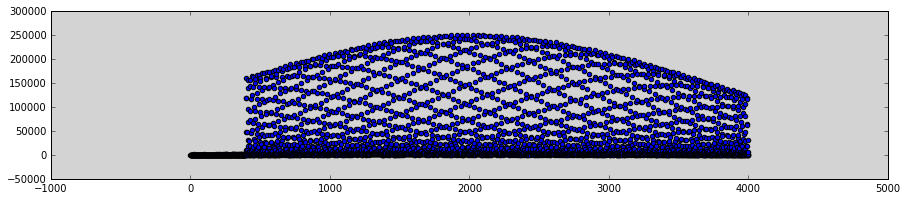

In [38]:
sgraph = Spectrograph(4000, 80, 10.0, 399.0, 1000.0, 300.0, 0.0075, 1.0, True)
lfc = LFC(250000, 400, sgraph.maxWl - 1, 11/347.0)
orders=[0]
xs, ys = sgraph.observe([lfc.simulate()], orders=orders)
plt.scatter(xs[0], ys[0])
# plt.xlim(1000, 1050)

# Finding maxima

In [29]:
def plot_spectrum(ss_xs, ss_ys, y_preds, guess_x, fac, sol):
    for i in range(0, len(ss_xs)):
        plt.scatter(ss_xs[i], ss_ys[i], color='magenta')
        plt.plot(ss_xs[i], y_preds[i])
#         plt.scatter(ss_x, ss_obs[i], color='blue')
#         plt.plot(ss_x, pred_obs, color='red')
#         for peak in pred_peaks:
#             plt.axvline((peak - sgraph.minWl) * sgraph.fac, color='green')
#         for peak in lfc_peaks:
#             plt.axvline((peak - sgraph.minWl) * sgraph.fac, color='purple')
#         plt.axvline(guess_x, color='turquoise')
        if i == 0:
#             plt.xlim(sgraph.wl_to_pix(lfc.minWl - 3 * lfc.dWl), sgraph.wl_to_pix(lfc.minWl + 12 * lfc.dWl))
#             plt.xlim(sgraph.wl_to_pix(lfc.minWl - 3 * lfc.dWl), sgraph.wl_to_pix(lfc.minWl - 3 * lfc.dWl) + 50)
            plt.xlim(guess_x - 3 * lfc.dWl * fac, guess_x + 12 * lfc.dWl * fac)
            plt.axvline(guess_x, color='turquoise')
            plt.axvline(sol, color='purple')
        elif i == 1:
            plt.xlim(4100, 4150)
#             plt.xlim(sgraph.wl_to_pix(400), sgraph.wl_to_pix(401))
        plt.show()
#         plt.savefig('lol{}.png'.format(i))
        
    

In [30]:
def get_peaks(shift, lfc, n):
    peaks = np.empty(0)
    current = shift
    for i in range(0, n):
        peaks = np.append(peaks, current)
        current += lfc.dWl
    return peaks
    
def pred_error(y, pred_y, solution, prediction):
    lse = np.mean(np.abs(y - pred_y))
    error = np.abs(solution - prediction) / solution * 3e8
    return lse, error
    
def guess_min(x, y):
    guess_x = x[y > 2000]
    guess_y = y[y > 2000]
    max_idx = signal.argrelextrema(guess_y, np.greater, order=10)
    guess_max_x = guess_x[max_idx]
    guess_max_y = guess_y[max_idx]
    guess_x = guess_max_x[0]
    guess_y = guess_max_y[0]
    return guess_x, guess_y

In [31]:
rand = np.random.random(1)[0]
# def __init__(self, xres, nOrders, orderSize, minWl, bgrNoiseMu, bgrNoiseSD, fwhm, precision):
sgraph = Spectrograph(4000, 80, 10.0, 399.0, 1000.0, 300.0, 0.0075, 1.0, True)
# def __init__(self, intensity, minWl, maxWl, dWl):
lfc = LFC(1000000, 400 + rand, 430 + rand, 0.03)

In [43]:
def find_lfc_peaks(sgraph, lfc):
    lfc_peaks = lfc.getPeaks()
    
    def per_gauss_fit(wl, minWl):
        result = per_gauss(wl, sgraph.sigma * sgraph.fac, minWl, minWl + (len(lfc_peaks)) * lfc.dWl * sgraph.fac, 
                         lfc.dWl * sgraph.fac, lfc.intensity)
        if sgraph.blaze:
            sigma = fsr / (2.0 * np.sqrt(2.0 * np.log(2)))  # Assume FWHM of blaze is FSR of order
            result = result * np.exp(-(wlSpace - mid) ** 2 / (2.0 * sigma ** 2)) 
        return result
    
    print('Solution is: {}pix or {}nm'.format(sgraph.wl_to_pix(lfc.minWl), lfc.minWl))

    xs, ys = sgraph.observe([lfc.simulate()], orders=[0])
    x = xs[0]
    y = ys[0]
    
    # Do a cubic interpolation of x and y 
    spl = interpolate.UnivariateSpline(x, y, k=3)
    # ss stands for supersampled
    ss_x = np.linspace(0, sgraph.xres, 20000, dtype=np.float64)
    ss_y = spl(ss_x)
#     ss_x = x
#     ss_y = y
    ss_y[ss_y <= 0.0] = 1e-15
    
    # Fit on interpolated data
    guess_x, guess_y = guess_min(ss_x, ss_y)
    print('Initial guess for shift is: {}pix or {}nm'.format(np.asarray([guess_x]), sgraph.pix_to_wl(guess_x)))
    
    # Use lmfit for fitting
    gmod = lmfit.Model(per_gauss_fit)
    result = gmod.fit(ss_y, wl=ss_x, minWl=guess_x, method='lbfgsb', 
                      options={'ftol':1e-20, 'gtol':1e-20, 'maxiter':20000*(len(ss_x) + 1), 'factr':1.0, 'disp':True, 
                               'eps':np.finfo(np.float64).eps, 'maxls':100, 'maxfun':100000, 'maxcor':100})
#     result = gmod.fit(ss_y, wl=ss_x, minWl=guess_x, method='leastsq', 
#                       options={'disp': True, 'xtol': 1e-20, 'ftol': 1e-20, 'maxiter':20000000, 'maxfev':200000})
    pred_shift = result.params['minWl'].value
    y_pred = result.best_fit
    nfev = result.nfev
    pred_shift_wl = sgraph.pix_to_wl(pred_shift)
    print('Predicted shift is: {}pix or {}nm'.format(np.asarray([pred_shift]), pred_shift_wl))
    print('Number of calls: {}'.format(nfev))
    
    pred_peaks = get_peaks(pred_shift_wl, lfc, len(lfc_peaks))
    
    print(lfc_peaks[0:3], lfc_peaks[-3:])
    print(pred_peaks[0:3], pred_peaks[-3:])
    
    lse, error = pred_error(ss_y, y_pred, lfc.minWl, pred_shift_wl)
    print('Least squares error is {}'.format(lse))
    print('Error is: {}m/s'.format(error))
    
    plt.scatter(ss_x, ss_y, color='blue')
    plt.scatter(x, y, color='magenta')
    plt.plot(ss_x, y_pred, color='red')
    for peak in pred_peaks:
        plt.axvline((peak - sgraph.minWl) * sgraph.fac, color='green')
    for peak in lfc_peaks:
        plt.axvline((peak - sgraph.minWl) * sgraph.fac, color='purple')
    plt.axvline(guess_x, color='turquoise')
    plt.xlim(sgraph.wl_to_pix(lfc.minWl - 3 * lfc.dWl), sgraph.wl_to_pix(lfc.minWl + 12 * lfc.dWl))
    fig = plt.show()
    
    return ss_x, ss_y, pred_shift

In [44]:
%%time
error = find_lfc_peaks(sgraph, lfc)

Solution is: 400.0pix or 400nm
Initial guess for shift is: [ 400.020001000050001]pix or 400.000050003nm
 - Adding parameter "minWl"


NameError: global name 'fsr' is not defined

Solution is: 769.008550069pix or 400.922521375nm
Initial guess for shift is: [ 769.046152307615444]pix or 400.922615381nm
 - Adding parameter "shift"
Predicted shift is: [ 769.007958573208498]pix or 400.922519896nm
Number of calls: 11
Least squares error is 998.513168351
Error is: 1.10650182653m/s
Solution is: 769.008550069pix or 400.922521375nm
Initial guess for shift is: [ 769.046152307615444]pix or 400.922615381nm
 - Adding parameter "shift"
Predicted shift is: [ 769.008399670359836]pix or 400.922520999nm
Number of calls: 11
Least squares error is 998.03544253
Error is: 0.281347718202m/s
Solution is: 769.008550069pix or 400.922521375nm
Initial guess for shift is: [ 769.046152307615444]pix or 400.922615381nm
 - Adding parameter "shift"
Predicted shift is: [ 769.041646091055213]pix or 400.922604115nm
Number of calls: 7
Least squares error is 6917.87823466
Error is: 61.9122537491m/s
Solution is: 769.008550069pix or 400.922521375nm
Initial guess for shift is: [ 769.046152307615444]pix o

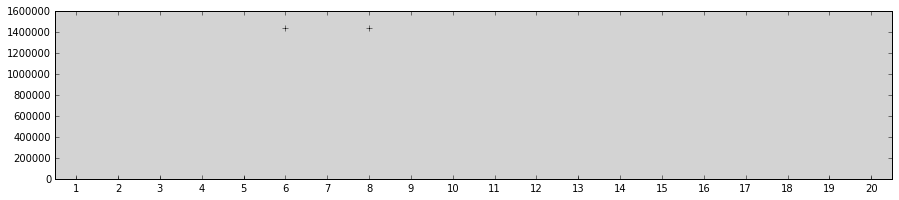

Stored 'x' (ndarray)
Stored 'y' (ndarray)
CPU times: user 50min 49s, sys: 86.7 ms, total: 50min 49s
Wall time: 50min 46s


In [93]:
%%time
# Make a plot of error to SNR
nTests = 5
intenStep = 25000
rang = range(20000, 500000, intenStep)
x = np.zeros(len(rang))
y = np.zeros((len(rang), nTests))
# nTests = 2
# intenStep = 300000
i = 0
for intensity in rang:
    sgraph = Spectrograph(4000, 80, 10.0, 399.0, 1000.0, 300.0, 0.0075, 1.0)
    lfc = LFC(intensity, 400 + rand, 430 + rand, 0.03)
    # Run 10 tests with each
    x[i] = intensity
    newY = []
    for j in range(0, nTests):
#         newY += find_lfc_peaks(sgraph, lfc, 1)
#         newY.append(np.random.random(1)[0] * i)
        newY.append(find_lfc_peaks(sgraph, lfc, 1))
    y[i] = np.asarray(newY)
    i = i + 1

plt.boxplot(np.transpose(y))
plt.show()
%store x
%store y

# Notes
**For future**:
- Make a table of effect of increasing the lfc intensity
- Create plot of jitter to error
- Resolution = wl of order / (wl to pix ratio) -> 400 / 0.025
- 80 orders [pix, intens, order]
- Further away orders are distorted
- Should use adjacent order
- Generate plots of SNR to error in cm/s
    - Moving Sigma from 2 to 4, R from 50,000 to 20,0000
- Paper submission to PASP

**Open questions**:
- Spectrograph error distribution: what is a good mean and a mean sdev?
- Doing least squares: should I weight according to error? For example, know error increases with intensity


**Todays notes**:
Stop plot at SNR 500 (intensity 250,000)

IOP paper guidelines

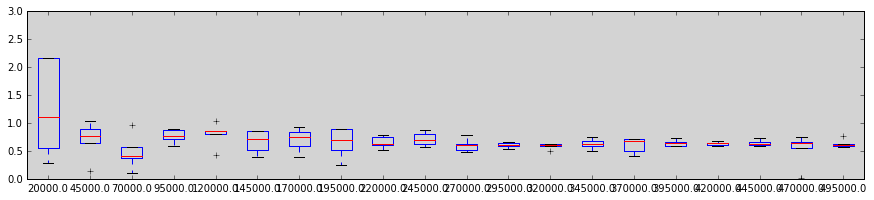

In [6]:
plt.boxplot(np.transpose(y), labels=x)
plt.ylim(0,3)
plt.show()

In [7]:
print(y)

[[  1.106501826532583e+00   2.813477182016292e-01   6.191225374913857e+01
    2.156866791440448e+00   5.537402723063505e-01]
 [  8.974446246723550e-01   6.429877918381043e-01   7.601941095941468e-01
    1.032756291152302e+00   1.369483076918877e-01]
 [  5.667681966643364e-01   1.025058105617047e-01   3.809074214577599e-01
    4.002643043315719e-01   9.631142259180978e-01]
 [  7.656462626122092e-01   8.979599722716033e-01   8.829428810411805e-01
    5.887860783130388e-01   7.047122362230450e-01]
 [  8.582318870951848e-01   8.093716093712089e-01   1.042700636808150e+00
    8.492691943976607e-01   4.187846193131740e-01]
 [  7.206493054349916e-01   1.436686431976707e+06   5.158347039616085e-01
    8.613546400412077e-01   3.948585989512100e-01]
 [  7.520265562182096e-01   8.327955954220201e-01   9.310538715987353e-01
    5.807362178066229e-01   3.843747035845281e-01]
 [  2.524495888134414e-01   1.436686331484776e+06   7.021172084060975e-01
    8.869099006178963e-01   5.205546261344201e-01]


In [27]:
def find_lfc_peaks_mult_orders(sgraph, lfc, orderId):
    lfc_peaks = lfc.getPeaks()
    
    print('Solution is: {}pix or {}nm'.format(sgraph.wl_to_pix(lfc.minWl), lfc.minWl))

    space, obs = sgraph.observe([lfc.simulate()])
    
    bottom = False
    top = False
    mid = False
    orders = []
    spaces = []
    # Select relevant orders
    if orderId == 0: # If first order in spectrum
        bottom = True
        orders.append(obs[0])
        spaces.append(space[0])
        if len(obs) > 1:
            orders.append(obs[1])
            spaces.append(space[1])
    elif orderId == len(obs) - 1: # else if last
        top = True
        orders.append(obs[-1])
        spaces.append(space[-1])
        if len(obs) > 1:
            orders.append(obs[-2])
            spaces.append(space[-2])
    else: # else middle order
        mid = True
        orders.append(obs[orderId - 1])
        spaces.append(space[orderId - 1])
        orders.append(obs[orderId])
        spaces.append(space[orderId])
        orders.append(obs[orderId + 1])
        spaces.append(space[orderId + 1])
        
    ss_xres = 5 * sgraph.xres
    ss_xs = np.empty((len(orders), ss_xres))
    ss_ys = np.empty((len(orders), ss_xres))
    prev_range = None
    # Interpolate selected orders
    for i in range(0, len(orders)):
        x = spaces[i]
        y = orders[i]
        
        spl = interpolate.UnivariateSpline(x, y, k=3)
        # This is the tricky part. I need the 'distance' between orders, so that I can
        # align them in pixel space correctly. For now, I am assuming that they are adjacent
#         ss_x = np.linspace(order_range[0], order_range[1], ss_xres, dtype=np.float64)
        ss_x = np.linspace(x[0], x[-1], ss_xres)
        ss_y = spl(ss_x)
        ss_y[ss_y <= 0.0] = 1e-15
        
        ss_xs[i] = ss_x
        ss_ys[i] = ss_y
        
    # Paste orders together
    all_ss_x = np.concatenate(ss_xs)
    all_ss_y = np.concatenate(ss_ys)
    
    # Fit on interpolated data
    def per_gauss_fit(wl, shift):
        # per_gauss(wl, sigma, minWl, maxWl, period, amplitude):
        return per_gauss(wl, sgraph.sigma * sgraph.fac, all_ss_x[0] + shift, all_ss_x[-1] + shift, 
                         lfc.dWl * sgraph.fac, lfc.intensity)
    
    def err_func(shift):
        err = 0.0
        # Fit the same per_gauss on each order
        for i in range(0, len(ss_xs)):
            err += np.mean(np.abs(per_gauss_fit(ss_xs[i], shift) - ss_ys[i]))
        return err
        
    guess_x, guess_y = guess_min(ss_xs[0], ss_ys[0])
    print('Initial guess for shift is: {}pix or {}nm'.format(np.asarray([guess_x]), sgraph.pix_to_wl(guess_x)))
    
    gmod = lmfit.Model(per_gauss_fit)
    # Should weight as well!!
    result = gmod.fit(all_ss_y, wl=all_ss_x, shift=guess_x, method='lbfgsb', 
                      options={'ftol':1e-20, 'gtol':1e-20, 'maxiter':20000*(len(ss_x) + 1), 'factr':1.0, 'disp':True, 
                               'eps':np.finfo(np.float64).eps, 'maxls':100, 'maxfun':100000, 'maxcor':100})
    pred_shift = result.params['shift'].value
    all_y_pred = result.best_fit
    nfev = result.nfev
    
    pred_shift_wl = sgraph.pix_to_wl(pred_shift)
    
    print('Predicted shift is: {}pix or {}nm'.format(np.asarray([pred_shift]), pred_shift_wl))
    print('Number of calls: {}'.format(nfev))
  
    lse, error = pred_error(all_ss_y, all_y_pred, lfc.minWl, pred_shift_wl)
    print('Least squares error is {}'.format(lse))
    print('Error is: {}m/s'.format(error))
    
    plt.scatter(all_ss_x, all_ss_y, color='blue')
    plt.plot(all_ss_x, all_y_pred, color='red')
    plt.axvline(guess_x, color='turquoise')
#     plt.xlim(sgraph.wl_to_pix(lfc.minWl - 3 * lfc.dWl), sgraph.wl_to_pix(lfc.minWl + 12 * lfc.dWl))
    plt.xlim(7000, 7150)
    fig = plt.show()
    
    return error